# Effects of Averaging the data Pre-capacitor installation

Now we look at analyzing the signal to work out the curve.

In [1]:
import pandas as pd
import numpy as np
import unittest
import altair as alt

from src.data_processing import create_data_from_entry, flatten_data, time_period, unstable_seconds
from src.vizualization import generate_stability_rules, generate_line_chart

# Render altair charts correctly
alt.renderers.enable('notebook')

# Store the altair char json separately and not in the notebook to reduce
# notebook size
alt.data_transformers.enable('json')

%load_ext autoreload
%autoreload 2

## Load Data

First we import the calibrated data created in [Notebook 2](2-rdp-voltage-signal-exploration-pre-capacitor.ipynb). As we will only look at the first couple of packets of data, we only import the first 2000 rows.

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), "..", "data", "processed", "pre-capactitor-raw-data.csv"), nrows=2000)

In [3]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Datetime
0,90.371049,89.006572,88.368966,87.999155,84.658099,87.297788,86.985361,87.680352,87.457190,89.784452,...,91.671765,92.385884,93.144635,94.674890,93.291285,93.986275,93.661096,93.348669,91.608005,2018-09-21 16:56:48.930999994
1,93.246652,91.888552,90.619716,90.434810,88.745154,87.520950,88.413599,86.175602,86.704815,86.985361,...,88.872675,89.580418,90.479442,91.454979,92.424141,92.022449,93.514447,93.578207,92.819456,2018-09-21 16:56:49.041000128
2,91.486860,90.913014,88.292454,88.930060,88.209565,85.537996,87.285036,86.456148,86.596422,88.171309,...,89.746195,91.620757,92.035201,92.985234,94.387967,93.928891,93.559079,94.215813,91.952312,2018-09-21 16:56:49.367999792
3,89.344504,91.142552,90.804621,92.749320,92.105338,94.222189,93.348669,94.107420,93.565455,92.609046,...,89.905597,89.593170,87.967275,88.062916,85.735654,87.195771,86.035328,86.851464,88.209565,2018-09-21 16:56:49.640000105
4,87.731360,89.452897,91.066040,92.334876,92.570790,95.204103,93.329541,93.960771,93.463438,93.093627,...,90.696228,88.713274,88.171309,88.031035,85.722901,86.857840,86.985361,86.679310,87.565583,2018-09-21 16:56:49.912999868


In [4]:
data.tail()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Datetime
1995,91.518740,92.334876,93.214772,94.834291,93.667472,93.533575,93.272157,92.373132,91.244569,90.402930,...,88.451855,86.283995,87.214900,86.252114,87.546455,87.661224,89.401888,88.910931,90.772741,2018-09-21 17:06:14.700999975
1996,88.636761,87.240404,85.767534,87.610215,86.660182,86.889720,88.254197,89.248863,90.326417,91.977816,...,94.177557,93.010738,94.694018,92.813080,92.857713,91.608005,91.442227,88.949188,89.185102,2018-09-21 17:06:14.973999977
1997,93.106379,96.237024,92.864089,93.552703,93.514447,93.552703,92.347628,90.938519,88.515616,88.553872,...,86.985361,87.214900,86.570917,88.439103,87.897138,88.145804,90.179767,91.824791,91.168057,2018-09-21 17:06:15.302000046
1998,88.349838,87.425309,85.410475,87.112883,86.781327,87.253156,88.668641,89.032077,91.155305,91.410347,...,93.692976,93.406054,94.088292,93.074499,92.813080,91.467732,91.321082,89.344504,89.223358,2018-09-21 17:06:15.573999882
1999,85.302082,87.412557,86.532661,86.545413,88.171309,88.910931,90.052246,91.869423,92.972482,92.577166,...,93.342293,92.940601,92.392260,91.920432,90.766365,90.090503,88.687769,87.980027,86.762199,2018-09-21 17:06:15.845999956


## Averaging effect

The DAQ is sampling at 1000Hz collecting 100 samples before the DAQ sends the data to the IOC. This happens every 0.1 second so a new sample is taken every 1 millisecond.  As we are sampling at 1000Hz, we preserve the frequencies less than 500Hz (the Nyquist frequency). 

We now want to filter out the 50Hz signal. The 50Hz signal repeats every 1/50s = 20ms, so the 50Hz signal repeats every  20 samples. Thus, to alias out the 50Hz we need to average 2 samples which are ten samples apart.

We will now create a new data set where one row corresponds to the value generated by averaging 2 samples which are ten samples apart. Each non-datetime element (row, col) of this data set is the average of the values (row, col) and (row, col + 10).

In [5]:
def create_rolling_averages(row, increment=10):
    """
    Creates an array of rolling averages
    
    Args:
        row (pandas series): Row of a pandas dataframe.
        increment (int, optional): Increment of the point 
    Return:
        averages (list): Row for a pandas dataframe with rolling averages.
    """
    values = row.drop("Datetime")
    averages =  [np.mean([values[i], values[i + increment]]) for i in range(0, values.size - increment)]
    averages.insert(0, row["Datetime"])
    return averages

class AveragingTests(unittest.TestCase):
    
    def test_that_GIVEN_a_row_THEN_an_array_of_rolling_averages_is_produced(self):
        # Given:
        timestamp = datetime.datetime.utcnow()
        row = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, timestamp],
                        index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, "Datetime"])

        # Then:
        result = create_rolling_averages(row, increment=2)
        expected = [timestamp, 2, 3, 4, 5, 6, 7, 8, 9]

        self.assertEquals(result, expected)

        
unittest.main(argv=[''], verbosity=2, exit=False)

test_that_GIVEN_a_row_THEN_an_array_of_rolling_averages_is_produced (__main__.AveragingTests) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


In [6]:
filtered_data = data.apply(create_rolling_averages, axis=1, result_type='expand').rename(columns={0: "Datetime"})
filtered_data.head()

,Datetime,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2018-09-21 16:56:48.930999994,89.937477,90.307289,89.994862,90.479442,89.854588,90.284972,90.288160,91.110672,90.109631,...,90.074562,90.386989,90.425246,90.798245,90.205272,90.131947,90.603775,90.415682,90.320041,89.867340
1,2018-09-21 16:56:49.041000128,90.182955,90.109631,89.940665,90.508135,89.991674,90.320041,90.332793,90.128759,90.272220,...,90.122383,90.205272,90.399741,90.112819,90.163827,90.052246,90.422058,89.682435,90.444374,89.966169
2,2018-09-21 16:56:49.367999792,90.109631,90.345545,90.013990,90.549579,90.587835,90.457126,90.326417,90.128759,90.208460,...,89.899221,90.112819,90.240340,90.170203,90.645220,89.947041,90.575083,89.784452,90.540015,90.141511
3,2018-09-21 16:56:49.640000105,90.300913,90.810997,90.182955,90.409306,89.969357,89.848212,90.294537,90.128759,90.119195,...,90.399741,89.714315,90.533639,89.813144,90.125571,89.625050,90.495382,89.934289,90.422058,90.096879
4,2018-09-21 16:56:49.912999868,89.829084,90.141511,89.835460,90.399741,90.109631,90.106443,90.555955,90.163827,90.237152,...,90.275408,90.198896,90.135135,90.119195,90.540015,90.033118,90.205272,89.966169,90.313665,90.029930


## Comparison between raw data and filtered data

Lets look at how the filtering affects the mean and standard deviation of the signal.

First, we flatten the raw data and look at the mean and standard deviation and plot the data.

In [7]:
raw_data = flatten_data(data)
raw_data.head()

,Datetime,Value
0,2018-09-21 16:56:48.930999994,90.371049
1,2018-09-21 16:56:48.932099995,89.006572
2,2018-09-21 16:56:48.933199996,88.368966
3,2018-09-21 16:56:48.934299997,87.999155
4,2018-09-21 16:56:48.935399998,84.658099


In [8]:
raw_data.shape

(199900, 2)

In [9]:
data_mean = np.mean(raw_data)
data_mean

Value    90.241201
dtype: float64

In [10]:
data_std = np.std(raw_data)
data_std

Value    2.627201
dtype: float64

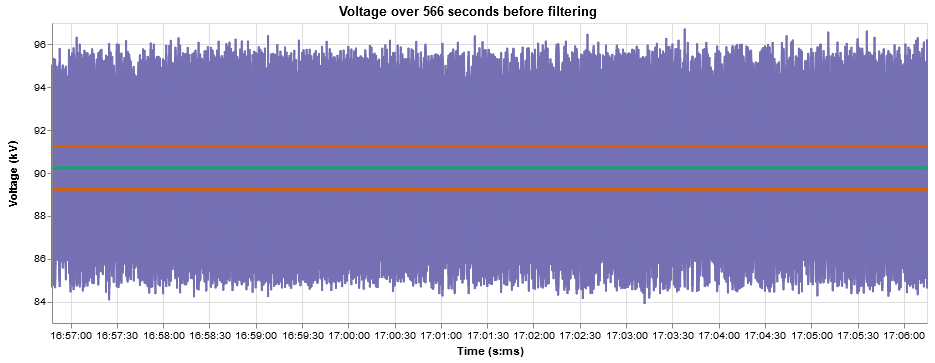

In [11]:
raw_stability_rules = generate_stability_rules(raw_data)
base = generate_line_chart(x_title="Time (s:ms)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds")

alt.layer(base, raw_stability_rules, data=raw_data, 
          title="Voltage over {} seconds before filtering".format(time_period(raw_data)), 
          config={"background": "white"},
          width = 875
         )

Now we flatten the filtered data and look at the mean and standard deviation

In [12]:
filtered_data = flatten_data(filtered_data)
filtered_data.head()

,Datetime,Value
0,2018-09-21 16:56:48.930999994,89.937477
1,2018-09-21 16:56:48.932099995,90.307289
2,2018-09-21 16:56:48.933199996,89.994862
3,2018-09-21 16:56:48.934299997,90.479442
4,2018-09-21 16:56:48.935399998,89.854588


In [13]:
filtered_data.tail()

,Datetime,Value
179905,2018-09-21 17:06:15.805199882,90.316853
179906,2018-09-21 17:06:15.807919882,89.720691
179907,2018-09-21 17:06:15.810639882,90.364673
179908,2018-09-21 17:06:15.813359882,89.969357
179909,2018-09-21 17:06:15.816079882,90.192520


In [14]:
filtered_mean = np.mean(filtered_data)
filtered_mean

Value    90.241475
dtype: float64

In [15]:
filtered_std = np.std(filtered_data)
filtered_std

Value    0.27138
dtype: float64

Lets look at the differences between the filtered mean and standard deviation and the original data.

In [16]:
data_mean - filtered_mean

Value   -0.000274
dtype: float64

In [17]:
1- filtered_std/data_std

Value    0.896704
dtype: float64

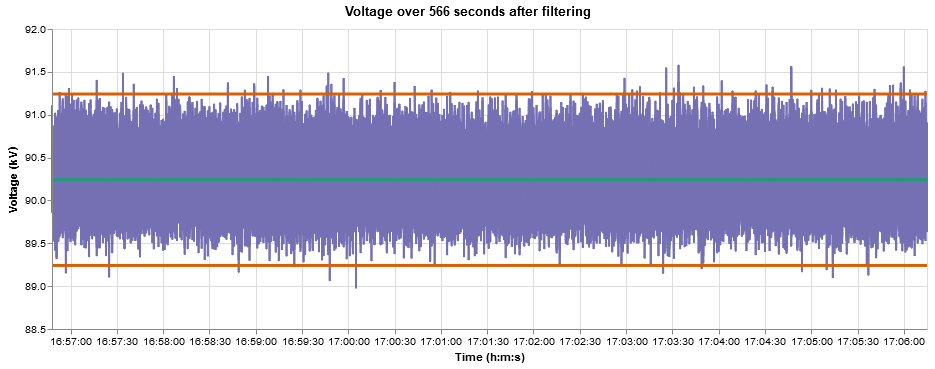

In [18]:
averaged_stability_rules = generate_stability_rules(filtered_data)

base = generate_line_chart(x_title="Time (h:m:s)", y_title="Voltage (kV)", y_scale=(88.5, 92), time_unit="hoursminutesseconds")

alt.layer(base, averaged_stability_rules, data=filtered_data,
          title="Voltage over {} seconds after filtering".format(time_period(filtered_data)), 
          config={"background": "white"},
          width = 875
         )

## Conclusion

By filtering the data using a rolling average to cancel the 50Hz signal we reduce the standard deviation of the signal by 89.6704%. As you can see from the charts above, the filtered signal is more stable. The max and min are now very close to the stability bounds. The filtered data has only 91ms seconds of instability in 10 minutes.

In [19]:
np.max(filtered_data["Value"])

91.585688650000009

In [20]:
np.min(filtered_data["Value"])

88.971504049999993

In [21]:
unstable_milliseconds = unstable_seconds(filtered_data, sampling_rate=1000) * 1000
unstable_milliseconds

91.0